In [1]:
import numpy as np
import numpy.linalg as la
import scipy.optimize as sopt
import matplotlib.pyplot as plt

# Location of Cities

Example from the website: http://www.benfrederickson.com/numerical-optimization/

In this example, given data on the distance between different cities, we want map out the cities by finding their locations in a 2-dimensional coordinate system. Below is an example of distance data that we may have available that will allow us to map a list of cities.

![Table of Distances Between Various Cities](city_table.png)

Let's load the data that we will be working with in this example.
`city_data` is an $n \times n$ numpy array where $n$ is the number of cities. `city_data` will store the table of distances between cities similar to the one above.

In [2]:
city_data = np.load('city_data.npy')

Before we start working with the data, we need to normalize the data by dividing by the largest element. This will allow us to more easily generate an initial guess for the location of each city.

In [3]:
city_data = city_data/np.max(city_data)

Below is a list of cities that we want to locate on a map.

In [4]:
city_names = [
    "Vancouver", 
    "Portland", 
    "New York", 
    "Miami", 
    "Mexico City", 
    "Los Angeles", 
    "Toronto", 
    "Panama City", 
    "Winnipeg", 
    "Montreal", 
    "San Francisco", 
    "Calgary", 
    "Chicago", 
    "Halifax", 
    "New Orleans", 
    "Saskatoon", 
    "Guatemala City", 
    "Santa Fe", 
    "Austin", 
    "Edmonton", 
    "Washington", 
    "Phoenix", 
    "Atlanta", 
    "Seattle", 
    "Denver"
  ]

The first step is to define the function that we need to minimize. One way to formulate this problem is using the following loss function:

$$
loss({\bf X}) = \sum_i \sum_j (({\bf X}_i - {\bf X}_j)^T({\bf X}_i - {\bf X}_j) - D_{ij}^2)^2
$$

- ${\bf X}_i$ and ${\bf X}_j$ are the positions for cities $i$ and $j$. Each position ${\bf X}$ has two components, the $x$ and $y$ coordinates. **These are the variables we want to find!**

- $({\bf X}_i - {\bf X}_j)^T({\bf X}_i - {\bf X}_j)$ is the squared-distance between cities $i$ and $j$, given the positions ${\bf X}_i$ and ${\bf X}_j$.

- $D_{ij}$ is the known distance between cities $i$ and $j$. **These are the given (known) variables provided in `city_data`.**

The loss function measures how much the actual location and the guess location differ. The optimization problem becomes:

$$ \min_{{\bf X}} loss({\bf X}) $$

Assume that the location of cities is stored as `city_loc`, a 1D numpy array of size $2n$, such that the x-coordinate of a given city is stored first followed by it's y-coordinate.

I.e.
$$
\text{city_loc} = 
\begin{bmatrix}
X_1[0]\\
X_1[1]\\
\vdots \\
X_n[0]\\
X_n[1]
\end{bmatrix}
$$

For example, if we had the cities Los Angeles, San Francisco and Chicago with their locations $(0.2,0.1),(0.2,0.5),(0.6,0.7)$, respectively, then `city_loc` would be
$$
\text{city_loc} = 
\begin{bmatrix}
0.2\\
0.1\\
0.2 \\
0.5\\
0.6\\
0.7
\end{bmatrix}
.
$$

**Try this out!**

Complete the objective function below:

In [23]:
def loss(city_loc, city_data):
    # city_loc: Numpy array of length 2n containing the x- and y-coordinates of all the cities
    # city_data: 2D Numpy array of length nxn containing the table of distances between cities  
    # totalLoss: Scalar with the output of the loss function for a given set of locations of cities
    totalLoss = 0.
    
    #clear
    n = len(city_loc)//2
    
    for i in range(n):
        for j in range(n):
            xij = city_loc[2*i:2*i+2] - city_loc[2*j:2*j+2]
            totalLoss += ( np.inner(xij,xij) - city_data[i,j]**2)**2
            
    #clear
    return totalLoss

Before we move on, let's check that our loss function is correct.

Check the output of your function on the following inputs. The loss function should evaluate to `0.2691297854852331`.

In [8]:
city_loc = np.array([0.2,0.1,0.2,0.5,0.6,0.7])
print(loss(city_loc,city_data[:3,:3]))

0.2691297854852331


Now that we have the function that we want to minimize, we need to compute it's gradient to use steepest descent.

$$
\begin{align}
\frac{\partial loss}{\partial X_k} =& \sum_i -4 ((X_i-X_k)^T(X_i-X_k) - D_{ik}^2) (X_i-X_k)
\\+& \sum_j 4 ((X_k-X_j)^T(X_k-X_j) D_{kj}^2) (X_k-X_j)
\end{align}
$$

In [9]:
def gradientLoss(city_loc, city_data):
    # city_loc: Numpy array of length 2n containing the x- and y-coordinates of all the cities
    # city_data: 2D Numpy array of length nxn containing the table of distances between cities    
    # grad: Numpy array of length 2n where n is the number of cities
    n = len(city_loc)
    grad = np.zeros(n)
    
    for k in range(n//2):
        for i in range(n//2):
            xik = city_loc[2*i:2*i+2] - city_loc[2*k:2*k+2]
            grad[2*k:2*k+2] += -4 * (np.dot(xik,xik) - city_data[i,k]**2) * xik

        for j in range(n//2):
            xkj = city_loc[2*k:2*k+2] - city_loc[2*j:2*j+2]
            grad[2*k:2*k+2] += 4 * (np.dot(xkj,xkj) - city_data[k,j]**2) * xkj
    return grad

Let's check that our gradient function is correct. Using the same input as we used in testing our loss function, the resulting gradient should be

`[ 0.14328835 -0.27303188  1.05797149  1.01695016 -1.20125985 -0.74391827]`.

In [10]:
city_loc = np.array([0.2,0.1,0.2,0.5,0.6,0.7])
print(gradientLoss(city_loc, city_data[:3,:3]))

[ 0.14328835 -0.27303188  1.05797149  1.01695016 -1.20125985 -0.74391827]


### Steepest descent using learning rate

We should now have everything that we need to use steepest descent if we use a learning rate instead of a line search parameter.

**Try it out!**

Complete the `steepest_descent` function below

- Store the solution after each iteration of steepest descent in a list called `city_loc_history`. To make plotting easier, we will reshape `city_loc` when we store it so that it is of shape $n \times 2$ instead of $2n$.

- Store the loss function after each iteration in a list called `loss_history`.

- Your algorithm should not exceed a given maximum number of iterations. 

- In addition, you should add a convergence stopping criteria. Here assume that the change in the loss function from one iteration to the other should be smaller than a given tolerance `tol`.


In [14]:
def steepest_descent(city_loc, learning_rate, city_data, num_iterations, tol):
    # city_loc: Numpy array of length 2n containing the x- and y-coordinates of all the cities
    # city_data: 2D Numpy array of length nxn containing the table of distances between cities  
    # learning_rate: Scalar with the learning rate that will be applied to steepest descent
    # num_iterations: Integer with the number of iterations to run steepest descent
    # tol: tolerance for the stopping criteria
    
    city_loc_history = [city_loc.reshape(-1,2)]
    loss_history = []
    
    for i in range(num_iterations):
    
        # write step of steepest descent here
        
        # append to city_loc_history
        
        # append to loss_history
        
        # check if tolerance is reached. if true then break
        
        #clear
        l = loss(city_loc, city_data)
        loss_history.append( l )        
        city_loc = city_loc - learning_rate * gradientLoss(city_loc, city_data)
        city_loc_history.append(city_loc.reshape(-1,2))
        
        if (i > 0):
            error = abs(loss_history[-2] - loss_history[-1])
            if ( error < tol ) :
                break
        #clear
        
    return city_loc_history, loss_history

Using your `steepest_descent` function, find the location of each city.
Use a random initial guess for the location of each of the cities and use the following parameters.

In [15]:
learning_rate = 0.005
num_iterations = 300
tol = 1e-5
city_loc = np.random.rand(2*city_data.shape[0])

city_loc_history, loss_history = steepest_descent(city_loc, learning_rate, city_data, num_iterations, tol)

We can use the `np.dstack` function to change the list of city locations into a numpy array.
We will have a 3D numpy array with dimensions $n \times 2 \times num\_iterations$.

In [16]:
city_loc_history = np.dstack(city_loc_history)

Now let's display the location of each of the cities.
Note, you can use `plt.text` to display the name of the city on the plot next to its location instead of using a legend. The following code snippet will plot the final location of the cities if we assume that we stored the result of steepest descent as `city_loc_history`.

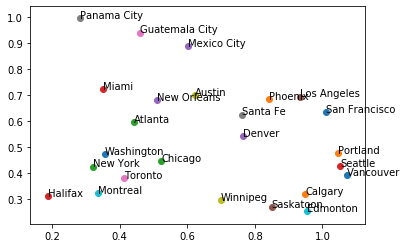

In [17]:
num_cities = city_loc_history.shape[0]

for i in range(num_cities):
    plt.scatter(city_loc_history[i,0,-1], city_loc_history[i,1,-1])
    plt.text(city_loc_history[i,0,-1], city_loc_history[i,1,-1], city_names[i])
plt.show()

Does your plot make sense? Keep in mind that we aren't keeping track of orientation (we don't have a fixed point for the origin) so you may need to "rotate" or "invert" your plot (mentally) for it to make sense.  Or if you want an extra challenge for after class, you can modify the optimization problem to include a fixed origin :-)

You can plot the history of the loss function, and observe the convergence of the optimization

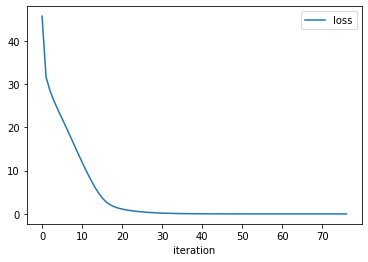

In [18]:
plt.plot(loss_history, label = 'loss')
plt.xlabel('iteration')
plt.legend()
plt.show()

Let's also include how location of each of the cities changes throughout the optimization iterations. The following code snippet assumes that the output for steepest descent is stored in `city_loc_history` and is a numpy array of shape $n \times 2 \times num\_iterations$

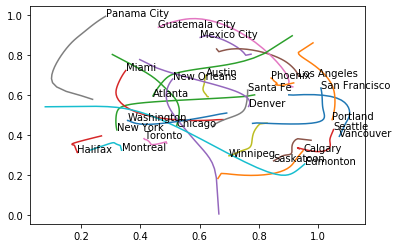

In [19]:
num_cities = city_loc_history.shape[0]

for i in range(num_cities):
    plt.plot(city_loc_history[i,0,:], city_loc_history[i,1,:])
    plt.text(city_loc_history[i,0,-1], city_loc_history[i,1,-1], city_names[i])
plt.show()

The plot looks too cluttered, right?
Repeat the same experiment but use a smaller number of cities. But don't forget to normalize the smaller data set. Use 10 cities for this smaller experiment.

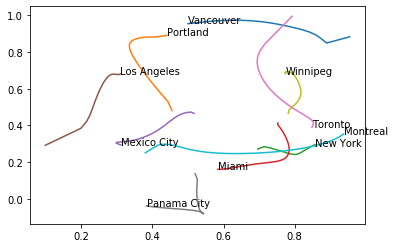

In [20]:
city_data2 = city_data[:10,:10]/np.max(city_data[:10,:10])
city_loc2 = np.random.rand(2*city_data2.shape[0])

learning_rate = 0.01
num_iterations = 300
tol = 1e-8

city_loc_hist2, loss_hist_2 = steepest_descent(city_loc2, learning_rate, city_data2, num_iterations,tol)
city_loc_hist2 = np.dstack(city_loc_hist2)

num_cities = city_loc_hist2.shape[0]
for i in range(num_cities):
    plt.plot(city_loc_hist2[i,0,:], city_loc_hist2[i,1,:])
    plt.text(city_loc_hist2[i,0,-1], city_loc_hist2[i,1,-1], city_names[i])
plt.show()

Let's see how the loss changes after each iteration. Plot the `loss_history` variable.

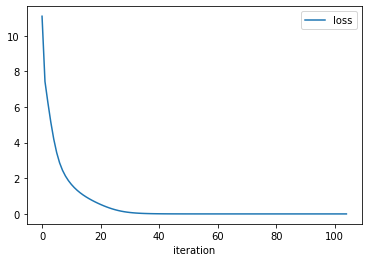

In [21]:
plt.plot(loss_hist_2, label = 'loss')
plt.xlabel('iteration')
plt.legend()
plt.show()

Repeat the same experiment but try different values for the learning rate.
What happens when we decrease the learning rate? Do we need more iterations?
What happens when we increase the learning rate? Do we need more or less iterations?

#### Steepest descent with golden-section search

Now, let's use golden-section search again for computing the line search parameter instead of a learning rate.

Wrap the function that we are minimzing so that $\alpha$ is a parameter. 

In [22]:
def objective_1d(alpha, city_loc, city_data):
    return loss(city_loc - alpha * gradientLoss(city_loc,city_data), city_data)

Rewrite your steepest descent function so that it uses `scipy.optimize.golden`. We will denote this new function as `sd_line`. Complete the function below:


In [24]:
def sd_line(city_loc, city_data, num_iterations, tol):
    # city_loc: Numpy array of length 2n containing the x- and y-coordinates of all the cities
    # city_data: 2D Numpy array of length nxn containing the table of distances between cities  
    # num_iterations: Integer with the number of iterations to run steepest descent
    # tol: tolerance for the stopping criteria
    
    city_loc_history = [city_loc.reshape(-1,2)]
    loss_history = []
    
    for i in range(num_iterations):
        
        # use the line search to find the learning rate alpha
        
        # write step of steepest descent here
        
        # append to city_loc_history
        
        # append to loss_history
        
        # check if tolerance is reached. if true then break
        
        #clear
        
        alph = sopt.golden(objective_1d, args=(city_loc,city_data))
        
        loss_history.append( loss(city_loc, city_data) )
        
        city_loc = city_loc - alph * gradientLoss(city_loc, city_data)
        
        city_loc_history.append(city_loc.reshape(-1,2))
        
        if (i > 0):
            error = abs(loss_history[-2] - loss_history[-1])
            if ( error < tol ) :
                break
                
        #clear
                
    return city_loc_history, loss_history


Use your new function for steepest descent with line search to find the location of the cities and plot the result. You can use the code snippets for plotting that we provided above.

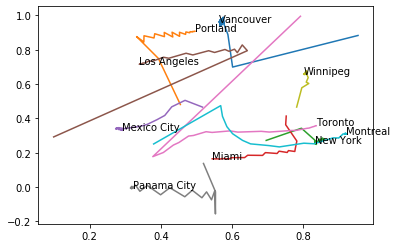

In [25]:
num_iterations = 300
tol = 1e-8

city_hist3, loss_hist3 = sd_line(city_loc2, city_data2, num_iterations, tol)
city_hist3 = np.dstack(city_hist3)

num_cities = city_hist3.shape[0]

for i in range(num_cities):
    plt.plot(city_hist3[i,0,:], city_hist3[i,1,:])
    plt.text(city_hist3[i,0,-1], city_hist3[i,1,-1], city_names[i])
plt.show()

What do you notice about how the solution evolves? Do you expect using a line search method that the solution will converge faster or slower? Will using a line search method increase the cost per iteration of steepest descent?

Plot the loss function at each iteration to see if it converges in fewer number of iterations.

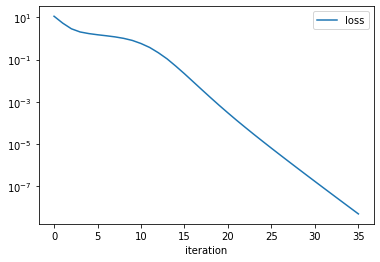

In [26]:
plt.semilogy(loss_hist3, label = 'loss')
plt.xlabel('iteration')
plt.legend()
plt.show()

In [27]:
city_hist3[:,:,-1]

array([[ 0.5636299 ,  0.96317703],
       [ 0.4962236 ,  0.90762046],
       [ 0.83310358,  0.25550344],
       [ 0.54472453,  0.16446954],
       [ 0.29201932,  0.33099136],
       [ 0.34002054,  0.71535808],
       [ 0.83670773,  0.35752101],
       [ 0.32089979, -0.00692105],
       [ 0.80193702,  0.65708406],
       [ 0.92042788,  0.31059944]])

#### Using scipy function

We can now compare the functions you defined above with the `minimize` function from `scipy`

In [28]:
import scipy.optimize as sopt

num_cities = 10
tol = 1e-5

city_data_small = city_data[:num_cities,:num_cities]/np.max(city_data[:num_cities,:num_cities])
x0 = np.random.rand(2*city_data_small.shape[0])

In [29]:
# Providing only the function to the optimization algorithm 
# Note that it takes a lot more function evaluations for the optimization, since
# gradient and Hessians are approximated in the backend
res1 = sopt.minimize(loss, x0, args=(city_data_small), tol=tol )
xopt1 = res1.x.reshape(num_cities,2)
print(xopt1)
print('Optimized loss value is ', res1.fun)
print('converged in', res1.nit, 'iteration with', res1.nfev, 'function evaluations' )

[[0.32585222 0.9859268 ]
 [0.40755986 0.9551058 ]
 [0.29930053 0.22914593]
 [0.60164059 0.23610872]
 [0.78702927 0.47530221]
 [0.61749116 0.82358062]
 [0.26295014 0.32453478]
 [0.86880086 0.14616083]
 [0.19913116 0.61927686]
 [0.19886533 0.25309397]]
Optimized loss value is  7.840331992154835e-13
converged in 30 iteration with 902 function evaluations


In [30]:
# Providing function and gradient to the optimization algorithm
# Note that the number of function evaluations are reduced, since only Hessian are now approximated
res2 = sopt.minimize(loss, x0, args=(city_data_small) , jac=gradientLoss, tol = tol )
xopt2 = res2.x.reshape(num_cities,2)
print(xopt2)
print('Optimized loss value is ', res2.fun)
print('converged in', res2.nit, 'iteration with', res2.nfev, 'function evaluations' )

[[0.325854   0.98593012]
 [0.40756163 0.95510912]
 [0.2993024  0.22914924]
 [0.60164245 0.23611207]
 [0.7870311  0.47530557]
 [0.61749294 0.82358397]
 [0.26295199 0.32453808]
 [0.86880274 0.14616422]
 [0.19913298 0.61928015]
 [0.1988672  0.25309726]]
Optimized loss value is  8.011110036525524e-13
converged in 30 iteration with 41 function evaluations


In [31]:
xhist,loss_hist = sd_line(x0, city_data_small, 400, tol)
xopt3 = xhist[-1]
print(xopt3)
print('Optimized loss value is ', loss_hist[-1])
print('convergend in ', len(loss_hist),'iterations')

[[0.42814725 1.0025419 ]
 [0.50133603 0.95554695]
 [0.24600659 0.26753989]
 [0.5434494  0.21215263]
 [0.77387548 0.40791504]
 [0.68018517 0.78333572]
 [0.2297401  0.36864044]
 [0.7852226  0.06853932]
 [0.22836776 0.6700637 ]
 [0.15230905 0.31199421]]
Optimized loss value is  1.0175044881362874e-05
convergend in  23 iterations


In [32]:
xhist,loss_hist = steepest_descent(x0, 0.01,  city_data_small, 400, tol)
xopt3 = xhist[-1]
print(xopt3)
print('Optimized loss value is ', loss_hist[-1])
print('convergend in ', len(loss_hist),'iterations')

[[0.33763254 0.98898065]
 [0.41618506 0.95593394]
 [0.2931569  0.23259952]
 [0.59584374 0.23303882]
 [0.78599203 0.46739309]
 [0.62379132 0.82021794]
 [0.25932761 0.32850052]
 [0.86179628 0.13817245]
 [0.20158309 0.62467806]
 [0.19333085 0.25875482]]
Optimized loss value is  3.477871508921977e-05
convergend in  63 iterations
